# Lab 6:  More on Convolutional Neural Networks

## Saturday, November 17th 2018

**David Sondak and Pavlos Protopapas**

This lab will cover the following topics:

* [Finish Training a Convnet from Scratch on a small dataset](#part0)
    * [Using a small dataset](#part21)
    * [The relevance of deep learning for small-data problems](#part22)
    * [Data setup](#part23)
    * [Building your network](#part24)
    * [Data preprocessing](#part25)
* [Data Augmentation](#part1) 
* [Comparing Two Networks](#part2)

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

<a id='part0'></a>
## Last Time - Training a Convnet from Scratch on a small dataset


<a id='part21'></a>
### Part 2.1 - Using a small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A "few" samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training: 1,000 for validation, and 1,000 for testing.

In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. You’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get you to a classification accuracy of 71%. At that point, the main issue will be overfitting. Then we’ll introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, you’ll improve the network to reach an accuracy of 82%.

<a id='part22'></a>
### Part 2.2 - The relevance of deep learning for small-data problems

You’ll sometimes hear that deep learning only works when lots of data is available. This is valid in part: one fundamental characteristic of deep learning is that it can find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high- dimensional, like images.

But what constitutes lots of samples is relative -- relative to the size and depth of the network you’re trying to train, for starters. It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple. Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You’ll see this in action in this section.

What’s more, deep-learning models are by nature highly repurposable: you can take, say, an image-classification or speech-to-text model trained on a large-scale dataset and reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pretrained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That’s what you’ll do in the next section. Let’s start by getting your hands on the data.

<a id='part23'></a>
### Part 2.3 - Data setup


The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream. The data has been downloaded for you from [https://www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data) 

The pictures are medium-resolution color JPEGs. Unsurprisingly, the dogs-versus-cats Kaggle competition in 2013 was won by entrants who used convnets. The best entries achieved up to 95% accuracy. In this example, you’ll get fairly close to this accuracy (in the next section), even though you’ll train your models on less than 10% of the data that was available to the competitors.

A new dataset containing three subsets has been created for you: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

In [4]:
# TODO: set your base dir to your correct local location
base_dir = 'cats_and_dogs_small'

import os, shutil

# Set up directory information

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir))) 
print('total training dog images:', len(os.listdir(train_dogs_dir))) 
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir))) 
print('total test dog images:', len(os.listdir(test_dogs_dir))) 


total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


So you do indeed have 2,000 training images, 1,000 validation images, and 1,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

<a id='part24'></a>
### Part 2.4 - Building your network

You built a small convnet for MNIST in the previous example, so you should be familiar with such convnets. You’ll reuse the same general structure: the convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

But because you’re dealing with bigger images and a more complex problem, you’ll make your network larger, accordingly: it will have one more `Conv2D + MaxPooling2D` stage. This serves both to augment the capacity of the network and to further reduce the size of the feature maps so they aren’t overly large when you reach the `Flatten` layer. Here, because you start from inputs of size $150 \times 150$ (a somewhat arbitrary choice), you end up with feature maps of size $7 \times 7$ just before the Flatten layer.


**NOTE:** The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from $148 \times 148$ to $7 \times 7$). This is a pattern you’ll see in almost all convnets.

Because you’re attacking a binary-classification problem, you’ll end the network with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [5]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

For the compilation step, you’ll go with the `RMSprop` optimizer. Because you ended the network with a single sigmoid unit, you’ll use `binary crossentropy` as the loss.

In [6]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

<a id='part25'></a>
### Part 2.5 - Data Preprocessing

As you know by now, data should be formatted into appropriately preprocessed floating-point tensors before being fed into the network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. Keras has a module with image-processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class ImageDataGenerator, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors. This is what you’ll use here.


In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let’s look at the output of one of these generators: it yields batches of $150 \times 150$ RGB images (shape `(20, 150, 150, 3)`) and binary labels (shape `(20,)`). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point:

In [8]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let’s fit the model to the data using the generator. You do so using the `fit_generator` method, the equivalent of `fit` for data generators like this one. It expects as its first argument a `Python` generator that will yield batches of inputs and targets indefinitely, like this one does. Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the steps_per_epoch argument: after having drawn `steps_per_epoch` batches from the generator—that is, after having run for `steps_per_epoch` gradient descent steps - the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

When using `fit_generator`, you can pass a `validation_data` argument, much as with the `fit` method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of `Numpy` arrays. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation

In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5, # TODO: should be 30
      validation_data=validation_generator,
      validation_steps=50)


# It’s good practice to always save your models after training.
model.save('cats_and_dogs_small_1.h5')

Epoch 1/5
100/100 [==============================] - 79s 786ms/step - loss: 0.6882 - acc: 0.5415 - val_loss: 0.6649 - val_acc: 0.5950
Epoch 2/5
100/100 [==============================] - 79s 794ms/step - loss: 0.6572 - acc: 0.6155 - val_loss: 0.6741 - val_acc: 0.5470
Epoch 3/5
100/100 [==============================] - 75s 755ms/step - loss: 0.6086 - acc: 0.6670 - val_loss: 0.6385 - val_acc: 0.6340
Epoch 4/5
100/100 [==============================] - 75s 753ms/step - loss: 0.5720 - acc: 0.6985 - val_loss: 0.6338 - val_acc: 0.6580
Epoch 5/5
100/100 [==============================] - 77s 773ms/step - loss: 0.5424 - acc: 0.7220 - val_loss: 0.5900 - val_acc: 0.6780


Let’s plot the loss and accuracy of the model over the training and validation data during training:

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(epochs, acc, 'ro', label='Training acc')
ax.plot(epochs, val_acc, 'b', label='Validation acc')
ax.set_title('Accuracy with data augmentation', fontsize=22)
ax.set_xlabel(r'Epochs', fontsize=22)
ax.set_ylabel(r'Accuracy', fontsize=22)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)

figL, axL = plt.subplots(1,1, figsize=(10,6))

axL.plot(epochs, loss, 'ro', label='Training loss')
axL.plot(epochs, val_loss, 'b', label='Validation loss')
axL.set_title('Loss with data augmentation', fontsize=22)
axL.set_xlabel(r'Epochs', fontsize=22)
axL.set_ylabel(r'Loss', fontsize=22)
axL.tick_params(labelsize=22)
axL.legend(fontsize=22)

These plots are characteristic of overfitting. The training accuracy increases linearly, whereas the validation accuracy stalls at 70–72%. The validation loss reaches its minimum after only five epochs and then stalls, whereas the training loss keeps decreasing linearly.

Because you have relatively few training samples (2,000), overfitting will be your number-one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: *data augmentation*.

<a id='part1'></a>
## Part 1 - Data Augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by *augmenting* the samples via a number of random transformations that yield believable-looking images. The goal is that at training time your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In `Keras`, this can be done by configuring a number of random transformations to be performed on the images read by the `ImageDataGenerator` instance. Let’s get started with an example.

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the [`Keras` documentation](https://keras.io/preprocessing/image/)). Let’s quickly go over this code:
* `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example, real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can
appear after a rotation or a width/height shift. Let’s look at the augmented images 

In [ ]:
from keras.preprocessing import image
fnames = [os.path.join(train_dogs_dir, fname) for
     fname in os.listdir(train_dogs_dir)]
img_path = fnames[3] # Chooses one image to augment
img = image.load_img(img_path, target_size=(150, 150))
# Reads the image and resizes it
x = image.img_to_array(img) # Converts it to a Numpy array with shape (150, 150, 3) 
x = x.reshape((1,) + x.shape) # Reshapes it to (1, 150, 150, 3)
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a `Dropout` layer to your model right before the densely connected classifier.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
# Let’s train the network using data augmentation and dropout.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)
# Note that the validation data shouldn’t be augmented!

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5, # TODO: should be 100
      validation_data=validation_generator,
      validation_steps=50)

model.save('cats_and_dogs_small_2.h5')

And let’s plot the results again. Thanks to data augmentation and dropout, you’re no longer overfitting: the training curves are closely tracking the validation curves. You now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(epochs, acc, 'ro', label='Training acc')
ax.plot(epochs, val_acc, 'b', label='Validation acc')
ax.set_title('Accuracy with data augmentation', fontsize=22)
ax.set_xlabel(r'Epochs', fontsize=22)
ax.set_ylabel(r'Accuracy', fontsize=22)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)

figL, axL = plt.subplots(1,1, figsize=(10,6))

axL.plot(epochs, loss, 'ro', label='Training loss')
axL.plot(epochs, val_loss, 'b', label='Validation loss')
axL.set_title('Loss with data augmentation', fontsize=22)
axL.set_xlabel(r'Epochs', fontsize=22)
axL.set_ylabel(r'Loss', fontsize=22)
axL.tick_params(labelsize=22)
axL.legend(fontsize=22)


By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per convolution layer, or the number of layers in the network), you may be able to get an even better accuracy, likely up to 86% or 87%. But it would prove difficult to go any higher just by training your own convnet from scratch, because you have so little data to work with. As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model.

<a id='references'></a>
### References and Acknowledgements

* Most of this lab is based on the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python), Chapter 5 written by the Francois Chollet, the author of Keras. It is a very practical introduction to Deep Learning. It is appropriate for those with some Python knowledge who want to start with machine learning.

<a id='part2'></a>
## Part 2 - Comparing Two Networks

We will now compare a Fully Connected Network (Multi-Layer Perceptron, MLP) and a simple CNN on the task of image classification. We'll use a well known open dataset: CIFAR10. We will be using `Keras` for our networks.  Rather than use the usual `Keras` API, we will use the [functional API](https://keras.io/getting-started/functional-api-guide/).

You are using the CIFAR10 dataset in your current homework assignment.  CIFAR10 is a classic dataset released by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton (Machine learning legends). It consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

Here are some examples of the images in the dataset:

<img style="width:500px; height:400px" src="http://clouddatafacts.com/_images/cifar_10.png">


As you know, `Keras` allows us to easily imports well-known datasets like CIFAR10. We'll import the CIFAR10 dataset with `keras.datasets.cifar10.load_data()`. This will return two tuples of `numpy` arrays: `(x_train, y_train), (x_test, y_test)`. 

After that, we will implement an MLP and a CNN to classify the 10 classes of CIFAR10. 

Keras can build models in two different ways: *Sequential* and *Functional*. 

The Sequential API is a good starting point, as it allows you to easily create models layer by layer. This is the API that we've been using for the entire session so far.  Building a Sequential model just requires you to instantiate a `Sequential()` object with `model = Sequential()`, and adding layers after that is easily done with `model.add(layer)`. This API has several limitations:  it does not allow you to easily create bypass connections, share layers between models or have multiple inputs or outputs.

Small review example of the Sequential API:
```python
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=1))
model.add(Dense(1))
```

The [functional API](https://keras.io/getting-started/functional-api-guide/) allows you to create models that have a lot more flexibility as you can easily define models where layers connect to more than just the previous and next layers. You can connect layers to any other layer, add more inputs to your network (even in the middle of it) and concatenate outputs easily. Creating complex networks, such as [ResNets](https://arxiv.org/abs/1512.03385), becomes feasible.

The same exact network as above, using the functional API, is:
```python
# We define an Input layer
inp = Input(shape=(1,))

# We instantiate a Dense layer and connect it to the previous layer with (inp)
x = Dense(10)(inp)

out = Dense(1)(x)

# We build the full model
model = Model(inputs=inp, outputs=out)
```

We will be using the Functional API in this lab, as this is the main mode that you will be using should you decide to build a serious network.

### Import the Dataset

In [10]:
# Imports
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.datasets import cifar10

We import the `CIFAR10` dataset, one-hot encode the labels and scale the training and test data.

In [18]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # Load CIFAR10 dataset

# Convert to categorical
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Scale the data
x_train = x_train / 255
x_test = x_test / 255

Let's plot some of the images to get a feeling for what we're dealing with.

Text(0.5, 0.98, 'Testing images')

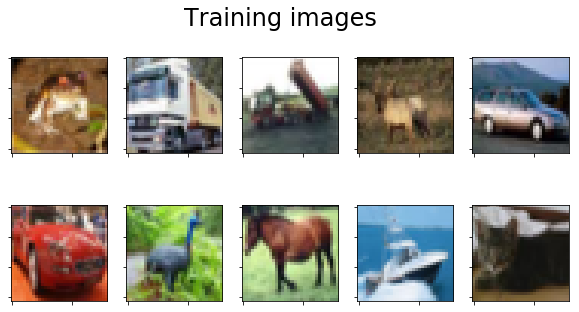

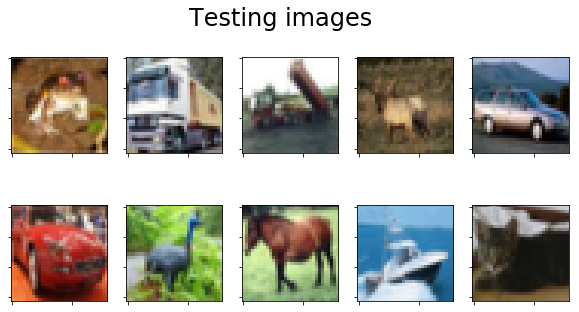

In [21]:
fig, ax = plt.subplots(2,5, figsize=(10,5))
row = 0
for i in range(10):
    if i > 4:
        row = 1
    ax[row][i%5].imshow(x_train[i])
    ax[row][i%5].tick_params(labelbottom=False, labelleft=False)

plt.suptitle('Training images', fontsize=24)
    
fig, ax = plt.subplots(2,5, figsize=(10,5))
row = 0
for i in range(10):
    if i > 4:
        row = 1
    ax[row][i%5].imshow(x_train[i])
    ax[row][i%5].tick_params(labelbottom=False, labelleft=False)

plt.suptitle('Testing images', fontsize=24)

#### The MLP
We will use the `Keras` functional API to build a fully-connected network with the following layers:
1. Input layer
2. Flatten layer (so that we can feed easily to Dense layers afterwards)
3. Dense layer, 512 nodes, relu activation
3. Dropout layer, 0.2 probability
4. Dense layer, 512 nodes, relu activation
3. Dropout layer, 0.2 probability
5. Dense layer, 256 nodes, relu activation
3. Dropout layer, 0.2 probability
5. Dense layer, 128 nodes, relu activation
3. Dropout layer, 0.2 probability
6. Dense layer, 10 nodes, softmax activation

In [ ]:
# MLP network

inp = Input(shape = (32,32,3))
x = Flatten()(inp)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=inp, outputs=x)

model.summary()

Now we'll compile the model and train it.

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs = 10, validation_split=0.2)

All trained!  That took a while on the CPU, but we made it through.  Now we need to evaluate the peformance on our test set.

In [ ]:
model.evaluate(x_test, y_test)

Now it's your turn.

Build a CNN with the following layers:
1. Conv2D, 32 3x3 filters, (1,1) strides, padding=same, activation=relu, use_bias=True
2. Conv2D, 32 3x3 filters, (1,1) strides, padding=same, activation=relu, use_bias=True
3. Maxpool, strides (2,2), pool_size (2,2)
1. Conv2D, 64 3x3 filters, (1,1) strides, padding=same, activation=relu, use_bias=True
2. Conv2D, 64 3x3 filters, (1,1) strides, padding=same, activation=relu, use_bias=True
3. Maxpool, strides (2,2), pool_size (2,2)
1. Conv2D, 128 3x3 filters, (1,1) strides, padding=same, activation=relu, use_bias=True
2. Conv2D, 128 3x3 filters, (1,1) strides, padding=same, activation=relu, use_bias=True
3. Maxpool, strides (2,2), pool_size (2,2)
5. Flatten layer
6. Dropout layer, 0.2 probability
7. Dense layer, 512 nodes, relu activation
8. Dropout, 0.5 probability
9. Dense layer, 10 nodes, softmax activation


* Use the `Keras` functional API.
* Train the CNN network
* Evaluate the CNN model on the test data set
* Discuss the differences between the MLP and the CNN

**Remarks:**

Use the same loss function, optimizer, number of epochs, batch size, and validation split size as you did when you trained the MLP.

**Hints:**

Here are the definitions of generic Conv2D layers, MaxPooling2D layers, Dense, Flatten and Dropout layers:

```python
x = Conv2D(32, (3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
```

In [ ]:
# Your code here